In [82]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".5"

import jax
import jax.numpy as jnp
from jax.scipy.sparse.linalg import gmres
import numpy as np
import matplotlib.pyplot as plt
import abtem
import ase
from ase.units import _hplanck, _c, _me, _e

%matplotlib widget

jax.config.update("jax_enable_x64", True)

In [110]:

def solve_scattering_2d_jax(potential_grid, energy_ev, pixel_size_A, pad_factor=2, absorb_frac=0.15, absorb_strength=4.0):
    """
    Solves 2D scalar Helmholtz for a pixelized potential using JAX/FFT.
    
    Args:
        potential_grid: 2D numpy array of the electrostatic potential (in Volts)
        energy_ev: Energy of incident electron/particle in eV
        pixel_size_A: Size of one pixel in Angstroms
        pad_factor: How much to pad the grid to avoid periodic artifacts (2 = double size)
        absorb_frac: Fraction of grid on each side used for absorbing boundary
        absorb_strength: Strength of absorbing taper (larger = stronger damping)
    
    Returns:
        wave_final: 2D array of the total wave function (complex)
    """
    
    # --- 1. Physics Constants & Setup ---
    m0 = 510998.95000  # Rest mass energy in eV
    hc = 12398.4193    # eV * Angstrom

    hbar = _hplanck / (2*np.pi)
    m_ec2_ev = (_me * _c**2) / _e

    gamma = 1.0 + energy_ev / m_ec2_ev
    m_eff = gamma * _me

    # Converts V [V] into the Helmholtz source term (in 1/Å^2)
    V_scale = (2.0 * m_eff * _e / (hbar**2)) * 1e-20

    E = energy_ev
    wavelength = hc / jnp.sqrt(E * (E + 2 * m0))
    k0 = 2 * jnp.pi / wavelength
    
    # --- 2. Padding ---
    orig_shape = potential_grid.shape
    padded_shape = [s * pad_factor for s in orig_shape]
    pad_width = [( (p-o)//2, (p-o)-(p-o)//2 ) for p, o in zip(padded_shape, orig_shape)]
    V_padded = jnp.pad(jnp.array(potential_grid), pad_width, mode='constant')
    
    # --- 3. Absorbing boundary mask ---
    def taper_1d(n, frac, strength):
        n_abs = max(1, int(frac * n))
        w = jnp.ones(n)
        if n_abs > 0:
            t = jnp.linspace(0.0, 1.0, n_abs)
            edge = jnp.exp(-strength * (1.0 - jnp.cos(0.5 * jnp.pi * t))**2)
            w = w.at[:n_abs].set(edge)
            w = w.at[-n_abs:].set(edge[::-1])
        return w

    wx = taper_1d(padded_shape[0], absorb_frac, absorb_strength)
    wy = taper_1d(padded_shape[1], absorb_frac, absorb_strength)
    absorb_mask = wx[:, None] * wy[None, :]
    
    # --- 4. Green's Function in K-space (2D) ---
    kx = jnp.fft.fftfreq(padded_shape[0], d=pixel_size_A) * 2 * jnp.pi
    ky = jnp.fft.fftfreq(padded_shape[1], d=pixel_size_A) * 2 * jnp.pi
    KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
    K_sq = KX**2 + KY**2
    epsilon =  k0 * 0.1
    G0 = 1.0 / (k0**2 - K_sq + 1j * epsilon)

    # --- 5. Define Linear Operator ---
    @jax.jit
    def matvec(psi_flat):
        psi = psi_flat.reshape(padded_shape)
        source = V_scale * V_padded * psi
        scattered = jnp.fft.ifftn(G0 * jnp.fft.fftn(source))
        scattered = scattered * absorb_mask
        return (psi - scattered).ravel()

    # --- 6. Incident Wave (plane wave along +y, top-to-bottom) ---
    y_coords = jnp.arange(padded_shape[1]) * pixel_size_A
    y_coords -= y_coords.mean()
    psi_inc_line = jnp.exp(1j * k0 * y_coords)
    psi_inc = jnp.broadcast_to(psi_inc_line, padded_shape)
    psi_inc = psi_inc * absorb_mask

    # --- 7. Solve with GMRES ---
    print(f"Solving 2D system with {np.prod(padded_shape)} unknowns...")
    psi_solution_flat, info = gmres(
        matvec,
        psi_inc.ravel(),
        tol=1e-6,
        restart=100
    )
    if info != 0:
        print(f"GMRES did not converge (info={info})")
    psi_solution = psi_solution_flat.reshape(padded_shape)

    # --- 8. Unpad ---
    starts = [p[0] for p in pad_width]
    ends = [s + o for s, o in zip(starts, orig_shape)]
    psi_final = psi_solution[starts[0]:ends[0], starts[1]:ends[1]]
    
    return psi_final


In [111]:
def wavelength_to_energy_ev(lam_angstrom):
    lam = lam_angstrom * 1e-10
    h = _hplanck
    c = _c
    m = _me
    p = h / lam
    E_total_J = np.sqrt((p * c) ** 2 + (m * c**2) ** 2)
    E_kin_J = E_total_J - (m * c**2)
    return E_kin_J / _e

# Beam energy from wavelength
wavelength_angstrom = 0.05
energy_ev = wavelength_to_energy_ev(wavelength_angstrom)

# 2D grid
nx, ny = 256, 256
roi_nz = 256
roi_xmin, roi_xmax = -2.0, 2.0
roi_ymin, roi_ymax = -2.0, 2.0
roi_zmin, roi_zmax = -2.0, 2.0

x = np.linspace(roi_xmin, roi_xmax, nx)
y = np.linspace(roi_ymin, roi_ymax, ny)
z = np.linspace(roi_zmin, roi_zmax, roi_nz)
dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1] - z[0]

# Build atomic potential (abTEM)
abtem.config.set({"device": "cpu"})
abtem.config.set({"precision": "float64"})

cell_x = roi_xmax - roi_xmin
cell_y = roi_ymax - roi_ymin
cell_z = roi_nz * dz
atoms = ase.Atoms("Au", cell=[cell_x, cell_y, cell_z], pbc=True)
atoms.center()

pot = abtem.Potential(atoms, gpts=(nx, ny), slice_thickness=dz, projection="finite")
pot_arr = pot.build(lazy=False).array  # (nz, ny, nx)

# Take a 2D slice near the center (z mid-plane), convert V·Å -> V
mid = pot_arr.shape[0] // 2
pot_2d = -pot_arr[mid, :, :].T / dz  # (nx, ny) = (x, y)
print("pot_2d stats (V):", pot_2d.min(), pot_2d.max())

pot_2d stats (V): -82424.19618454948 -0.16265940947016566


In [112]:
# Run 2D Solver
result_wave = solve_scattering_2d_jax(pot_2d, energy_ev=energy_ev, pixel_size_A=dx)

print(f"Done. Output shape: {result_wave.shape}")
print(f"Mean intensity: {jnp.mean(jnp.abs(result_wave)**2)}")

Solving 2D system with 262144 unknowns...
Done. Output shape: (256, 256)
Mean intensity: 1.3865665172325672


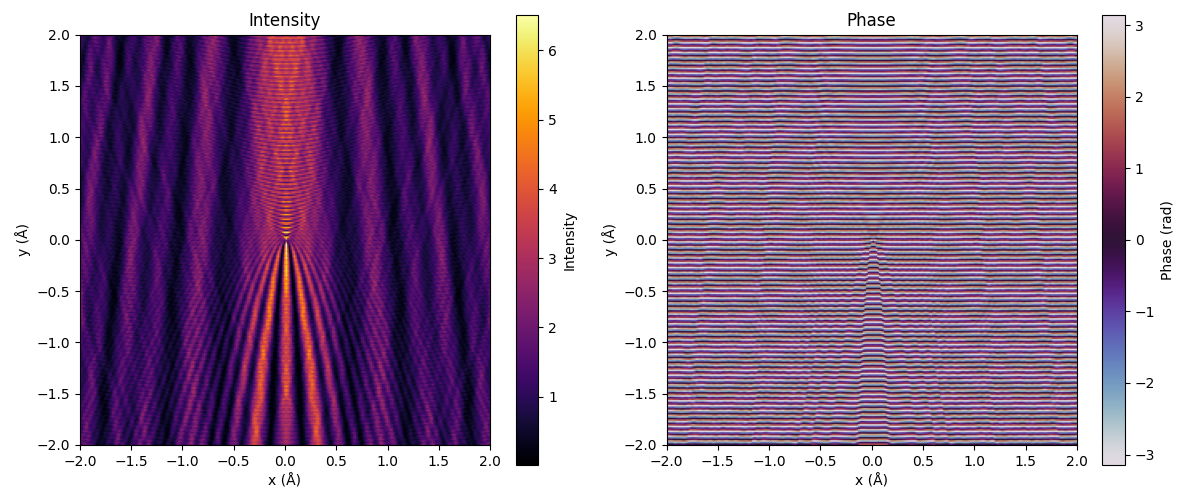

In [113]:
# Plot intensity and phase for the 2D solution
intensity = jnp.abs(result_wave) ** 2
phase = jnp.angle(result_wave)

# Transpose for display so x is horizontal and y is vertical
intensity_plot = np.asarray(intensity).T
phase_plot = np.asarray(phase).T

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im0 = axes[0].imshow(intensity_plot, origin='upper',
                     extent=(roi_xmin, roi_xmax, roi_ymin, roi_ymax), cmap='inferno')
axes[0].set_title('Intensity')
axes[0].set_xlabel('x (Å)'); axes[0].set_ylabel('y (Å)')
fig.colorbar(im0, ax=axes[0], label='Intensity')

im1 = axes[1].imshow(phase_plot, origin='upper',
                     extent=(roi_xmin, roi_xmax, roi_ymin, roi_ymax), cmap='twilight')
axes[1].set_title('Phase')
axes[1].set_xlabel('x (Å)'); axes[1].set_ylabel('y (Å)')
fig.colorbar(im1, ax=axes[1], label='Phase (rad)')

plt.tight_layout()
plt.show()

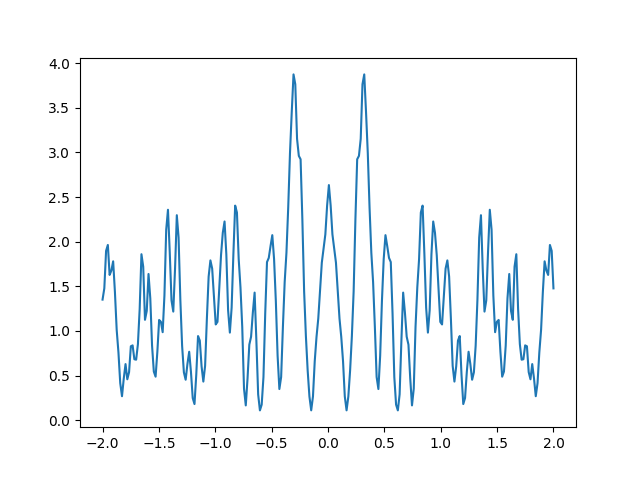

In [114]:
plt.figure()
plt.plot(y, np.abs(result_wave[:, -1])**2)